In [ ]:
import zipfile
with zipfile.ZipFile("/content/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spotify-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1800580%2F2936818%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T010052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7a095318cf8957bfd4914ad66ca3cc13ddf6bc1134cf7c51390b61242cb24b66a2ed57ef750e7985bb85d9ed9f605a5beb55ae65f822c9e313095e749aaa7e918d628438b6688d56e5dfb1348ae56cffea9f624619eada59e74a67920b51ec08f6daf795e9d06257346ea5cf0be1b3f09106afdbd2a7add2d459df99e0e61b6917617b22d690d548475f625f1c8bc5b8e62a6965b1df59eec070eeaed6b20ed970c213a041584dc06a4ce3b2f25f470bdb63b6000f1b337efc162760ff4dc44fd0649313fb80397b35a34a64ce13ea1c7039f389e04d2b8c024f12adb6a2adbc218a7f8e63b30f11de6479b6f73a99b3f9d45a55b48bb6f73b5e0b6a9c024774'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Spotify Veri Setleri ile Şarkı Öneri Sistemi**

# **Kütüphane Yükleme**

In [250]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

# **Verileri Okuma

In [251]:
data = pd.read_csv("/content/data/data.csv")
genre_data = pd.read_csv('/content/data/data_by_genres.csv')
year_data = pd.read_csv('/content/data/data_by_year.csv')

In [ ]:
print(data.info())

In [ ]:
print(genre_data.info())

In [ ]:
print(year_data.info())

We are going to check for all the analysis with the target as **'popularity'**. Before going to do that let's check for the Feature Correlation by considering a few features and for that, I'm going to use the **yellowbrick** package. You can learn more about it from the [documentation](https://www.scikit-yb.org/en/latest/index.html).

In [ ]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

features = np.array(feature_names)

visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)
visualizer.show()

# **Veri Görselleştirmesi**

# **Yıllara Göre Müzik**

Yıllara göre gruplandırılmış verileri kullanarak müziğin 1921 ve 2020 yılları arasındaki değişimini görmekteyiz.

<Axes: xlabel='count', ylabel='decade'>

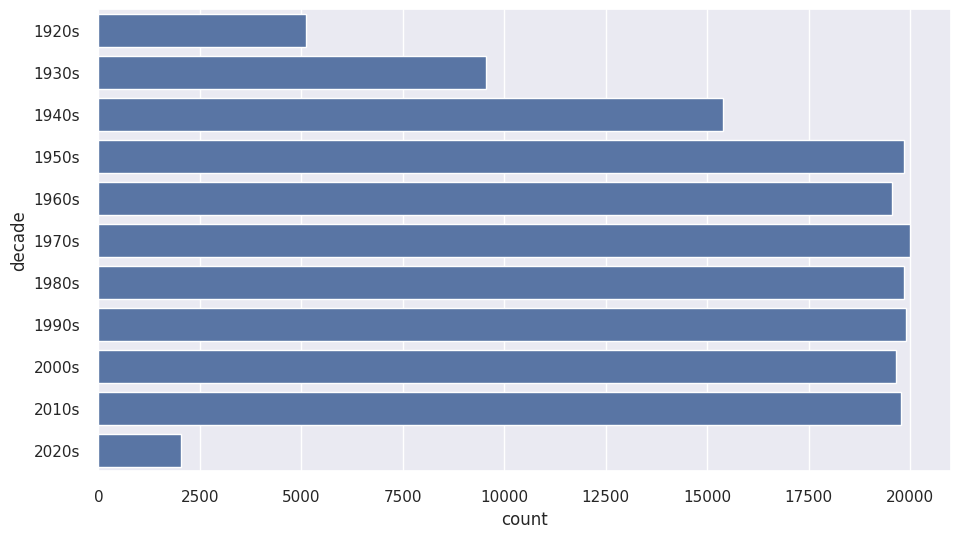

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(data['decade'])

In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='year', y=sound_features)
fig.show()

# **Türlere Atanan Parametreler**


In [ ]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

# **Şarkı Türlerinin Görselleştirilmesi**


In [ ]:
!pip install scikit-learn

In [252]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [ ]:
# Şarkı türlerinin görselleştirilmesi

from sklearn.manifold import TSNE

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

# **Şarkı İsimlerine Göre Veri Görselleştirmesi**

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=20,
                                   verbose=False))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

In [ ]:
# Başlıkların veri görselleştirilmesi

from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

In [ ]:
!pip install spotipy

In [254]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="aa96343daac04feb9210c59311e4ef7a",
                                                           client_secret="22b975444578402d9dd7f740fe0d1cd7"))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)


In [255]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib
import numpy as np
number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):

    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data

    except IndexError:
        return find_song(song['name'], song['year'])


def get_mean_vector(song_list, spotify_data):
    song_vectors = []
    expected_shape = len(number_cols)
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print(f'Warning: {song["name"]} does not exist in Spotify or in database')
            continue
        song_vector = song_data[number_cols].values
        if len(song_vector) == expected_shape:
            song_vectors.append(song_vector)
        else:
            print(f'Warning: {song["name"]} has an unexpected number of features. Skipping.')
    if not song_vectors:
        return None
    song_matrix = np.array(song_vectors)
    return np.mean(song_matrix, axis=0)



def flatten_dict_list(dict_list):

    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []

    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)

    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):

    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
recommend_songs([{'name': 'Come As You Are', 'year':1991},
                {'name': "What I've Done", 'year': 0}],  data)

In [ ]:
import gradio as gr

def parse_song_input(input_text):
    song_list = []
    lines = input_text.strip().split("\n")
    for line in lines:
        song_info = line.strip().split(", ")
        if len(song_info) == 2:
            song_list.append({"name": song_info[0], "year": int(song_info[1])})
    return song_list

def recommend_songs_interface(song_input):
    song_list = parse_song_input(song_input)
    recommendations = recommend_songs(song_list, data)
    formatted_recommendations = []
    for song in recommendations:
        formatted_recommendations.append(f"{song['name']} ({song['year']}) by {''.join(song['artists'])}")
    return "\n".join(formatted_recommendations)

interface = gr.Interface(
    fn=recommend_songs_interface,
    inputs="text",
    outputs="text",
    title="Song Recommender",
    description="Enter each song in the format 'Song Name, Year' on separate lines.",
    examples=["Come As You Are, 1991\nWhat I've Done, 2007"],
)

interface.launch()


In [ ]:
import pandas as pd

data = pd.read_csv("/content/data/data.csv")

print(data.head())
